In [1]:
# imports
import numpy as np

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from transformers import AutoTokenizer

from tqdm.auto import tqdm

from torch.nn.utils.rnn import pad_sequence

import matplotlib.pyplot as plt
from IPython.display import clear_output

import os
os.environ['http_proxy'] = "http://proxy-ws.cbank.kz:8080"
os.environ['https_proxy'] = "http://proxy-ws.cbank.kz:8080"

In [2]:
with open('data/anek.txt', 'r') as file:
    aneki = file.read().strip().replace('<|startoftext|>', '').split('\n\n')

In [3]:
aneki[555]

'Невероятно, но предложение "Не верьте всему, что находите в Интернете" читается в обе стороны одинаково!'

In [4]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")

print(len(tokenizer))

29564


/opt/conda/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
train_texts, test_texts = train_test_split(
    aneki,
    test_size=0.1,
    shuffle=True
)

In [6]:
def collate_fn(batch):
    batch_encoded = [torch.LongTensor(tokenizer.encode(text)) for text in batch]
    batch_padded = pad_sequence(batch_encoded, batch_first=True, padding_value=tokenizer.pad_token_id)
    return batch_padded

In [7]:
train_loader = DataLoader(
    train_texts, 
    batch_size=128, 
    shuffle=True,
    pin_memory=True,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_texts,
    batch_size=1,
    shuffle=False,
    pin_memory=True,
    collate_fn=collate_fn
)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Формула LSTM, йуху

$$
\begin{gathered}
f_t=\sigma\left(W_f \cdot\left[h_{t-1}, x_t\right]+b_f\right) \\
i_t=\sigma\left(W_i \cdot\left[h_{t-1}, x_t\right]+b_i\right) \\
o_t=\sigma\left(W_o \cdot\left[h_{t-1}, x_t\right]+b_o\right) \\
\tilde{C}_t=\tanh \left(W_c \cdot\left[h_{t-1}, x_t\right]+b_c\right) \\
C_t=f_t \odot C_{t-1}+i_t \odot \tilde{C}_t \\
h_t=o_t \odot \tanh \left(C_t\right)
\end{gathered}
$$

In [9]:
def assert_check_shapes(lhs_shape, rhs_shape):
    assertion_message = f"Not equal shapes: {lhs_shape} instead of {rhs_shape}"
    assert lhs_shape == rhs_shape, assertion_message

In [10]:
class LSTMCell(nn.Module):
    def __init__(self, num_tokens, embedding_size, hidden_embedding_size):
        super(self.__class__, self).__init__()
        self.num_tokens = num_tokens
        self.embedding_size = embedding_size
        self.hidden_embedding_size = hidden_embedding_size

        self.embedding_layer = nn.Embedding(num_embeddings=num_tokens, embedding_dim=embedding_size)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
        self.forget_linear = nn.Linear(embedding_size + hidden_embedding_size, hidden_embedding_size)
        self.input_linear = nn.Linear(embedding_size + hidden_embedding_size, hidden_embedding_size)
        self.output_linear = nn.Linear(embedding_size + hidden_embedding_size, hidden_embedding_size)
        self.short_memory_linear = nn.Linear(embedding_size + hidden_embedding_size, hidden_embedding_size)

        self.classifer_to_raw_logits = nn.Linear(hidden_embedding_size, num_tokens)
    
    def forward(self, x_input, last_hidden_state, last_short_memory):
        x_embed = self.embedding_layer(x_input)
        
        concat_state = torch.cat([x_embed, last_hidden_state], dim=-1)

        forget_mask = self.sigmoid(self.forget_linear(concat_state))
        input_mask = self.sigmoid(self.input_linear(concat_state))
        output_mask = self.sigmoid(self.output_linear(concat_state))
        short_memory_mask = self.tanh(self.short_memory_linear(concat_state))

        new_short_memory = torch.mul(forget_mask, last_short_memory) + torch.mul(input_mask, short_memory_mask)

        new_hidden_state = torch.mul(output_mask, self.tanh(new_short_memory))

        raw_logits = self.classifer_to_raw_logits(new_hidden_state)
        
        return {
            'short_memory' : new_short_memory,
            'hidden_state' : new_hidden_state,
            'raw_logits' : raw_logits
        }

    def get_empty_start_state(self, batch_size):
        return torch.zeros(batch_size, self.hidden_embedding_size, requires_grad=True)

In [11]:
# x_0, x_1, ..., x_(batch_len - 1)
# h_0 -> x_1
# h_1 -> x_2
# ...
# h_(batch_len - 2) -> x_(batch_len - 1)

# h_0, h_1, ..., h_(batch_len - 1)

# Обрезаем все логиты с конца 
# а последовательность с начала

def lstm_loop(lstm_cell: LSTMCell, batch: torch.Tensor):
    batch_size = batch.shape[0]
    
    last_hidden_state = lstm_cell.get_empty_start_state(batch_size).to(device)
    last_short_memory = lstm_cell.get_empty_start_state(batch_size).to(device)
    
    trans_batch = torch.transpose(batch, 1, 0)

    all_logits = []
    for batch_slice in trans_batch:
        output = lstm_cell(
            batch_slice.to(device), 
            last_hidden_state, 
            last_short_memory
        )

        last_short_memory = output['short_memory']
        last_hidden_state = output['hidden_state']
        raw_logits = output['raw_logits']

        all_logits.append(torch.Tensor(raw_logits))
    return {
        'all_logits' : torch.stack(all_logits[:-1], dim=1),
        'true_tokens' : torch.LongTensor(torch.transpose(trans_batch[1:], 1, 0))
    }

In [12]:
def train(lstm_cell):
    assert torch.cuda.is_available()
    
    loss_fun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(lstm_cell.parameters())
    loss_history = []
    
    for batch in tqdm(train_loader, 'Iterating batches...'):
        optimizer.zero_grad()
        res = lstm_loop(lstm_cell, batch)
    
        all_logits_flat = torch.flatten(res['all_logits'], start_dim=0, end_dim=1).to(device)
        true_tokens_flat = torch.flatten(res['true_tokens']).to(device)
    
        loss = loss_fun(all_logits_flat, true_tokens_flat)
        loss.backward()
        optimizer.step()
    
        loss_history.append(loss.data.item())
        clear_output(True)
        plt.plot(loss_history, label="loss")
        plt.legend()
        plt.show()

    return lstm_cell

In [13]:
lstm_cell = LSTMCell(
    num_tokens=len(tokenizer),
    embedding_size=1024,
    hidden_embedding_size=1024
).to(device)

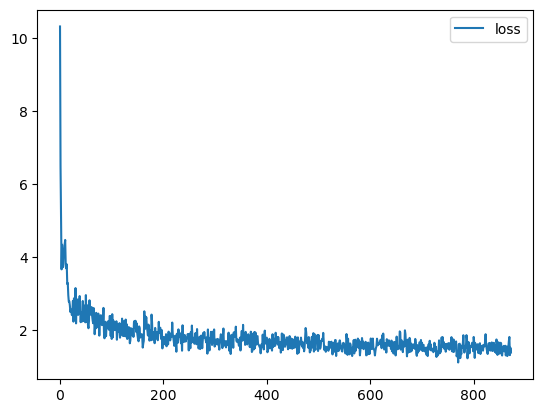

In [14]:
lstm_cell = train(lstm_cell)

In [15]:
@torch.inference_mode()
def evaluate_accuracy(lstm_cell: LSTMCell, test_loader, tokenizer):
    batch_size = test_loader.batch_size
    last_hidden_state = lstm_cell.get_empty_start_state(1).to(device)
    last_short_memory = lstm_cell.get_empty_start_state(1).to(device)

    true_tokens = []
    pred_tokens = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Inferencing batches...'):
            output = lstm_loop(lstm_cell, batch)
                
            argmax_logits = torch.argmax(output['all_logits'], dim=-1)

            true_tokens.extend(output['true_tokens'].tolist()[0])
            pred_tokens.extend(argmax_logits.tolist()[0])

    overall_acc_score = accuracy_score(
        true_tokens,
        pred_tokens
    )

    print("Macro accuracy score: ", round(overall_acc_score, 5))

In [ ]:
evaluate_accuracy(lstm_cell, test_loader, tokenizer)

Inferencing batches...:   0%|          | 0/12416 [00:00<?, ?it/s]

In [ ]:
@torch.inference_mode()
def generate(
    lstm_cell: LSTMCell, 
    max_length=100, 
    temperature=1.0, 
    top_k_count=10
):
    CLS_TOKEN_ID = tokenizer.cls_token_id
    SEP_TOKEN_ID = tokenizer.sep_token_id
    
    last_hidden_state = lstm_cell.get_empty_start_state(1).to(device)
    last_short_memory = lstm_cell.get_empty_start_state(1).to(device)

    generated_tokens = [CLS_TOKEN_ID]
    
    for i in range(max_length):
        output = lstm_cell(
            torch.LongTensor(generated_tokens[-1:]).to(device),
            last_hidden_state,
            last_short_memory
        )

        probas = F.softmax(output['raw_logits'] / temperature, dim=-1)
        
        topk_probas, topk_indices = probas.topk(top_k_count)
        normalized_topk_probas = topk_probas / topk_probas.sum()

        topk_indices = topk_indices.squeeze(dim=0)
        normalized_topk_probas = normalized_topk_probas.squeeze(dim=0)
        
        selected_token_index = np.random.choice(
            topk_indices.cpu().detach().numpy(), 
            p=normalized_topk_probas.cpu().detach().numpy()
        )

        if selected_token_index == SEP_TOKEN_ID:
            break
        
        generated_tokens.append(selected_token_index)
        
        last_hidden_state = output['hidden_state']
        last_short_memory = output['short_memory']

    return generated_tokens[1:]

In [ ]:
gen_count = 5

generated_token_indices = [generate(
    lstm_cell,
    max_length=400,
    top_k_count=20,
    temperature=1.0
) for i in range(gen_count)]

decoded_aneki = [tokenizer.decode(cur_indices) for cur_indices in generated_token_indices]

for anek in decoded_aneki:
    print(anek)
    print("--------------------------------")

### Пока коммитну вот так, перплексию и различные методы семплирования напишу потом